In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


# Data

Two datasets- **Hourly** apple performances and **Daily** apple performances

 

In [25]:
## Loading data and sorting

apple_df = pd.read_csv('/kaggle/input/apple-dataset/AAPL_Hourly_5MIN_2024_12_12_2025_01_10.csv')
apple_df.rename(columns = {'Unnamed: 0': 'Datetime'},inplace = True)
apple_df['Datetime'] = pd.to_datetime(apple_df['Datetime'])
apple_df['Return'] = apple_df['Close'] - apple_df['Close'].shift(1)
apple_df['LogReturn'] = np.log(apple_df['Close'] / apple_df['Close'].shift(1))
apple_df = apple_df.dropna()

## Setting Train and Test

n = apple_df.shape[0]
apple_train = apple_df.iloc[:int(np.ceil(n*0.7))]
apple_test = apple_df.iloc[int(np.ceil(n*0.7)):]
train_subset = apple_train[['Datetime','Close']]
test_subset = apple_test[['Datetime','Close']]

In [26]:
## Loading data and sorting

apple_intra_df = pd.read_csv('/kaggle/input/apple-intra/AAPL_2015_2024_newest.csv')
apple_intra_df.rename(columns = {'Unnamed: 0': 'Datetime'},inplace = True)
apple_intra_df['Datetime'] = pd.to_datetime(apple_intra_df['Datetime'])
apple_intra_df['Return'] = apple_intra_df['Close_daily'] - apple_intra_df['Close_daily'].shift(1)
apple_intra_df['LogReturn'] = np.log(apple_intra_df['Close_daily'] / apple_intra_df['Close_daily'].shift(1))
apple_intra_df = apple_intra_df.dropna()

## Setting Train and Test

n = apple_intra_df.shape[0]
apple_train_intra = apple_intra_df.iloc[:int(np.ceil(n*0.7))]
apple_test_intra = apple_intra_df.iloc[int(np.ceil(n*0.7)):]
train_subset_intra = apple_train_intra[['Datetime','Return']]
test_subset_intra = apple_test_intra[['Datetime','Return']]

In [143]:
apple_df.head()

,Datetime,Open,High,Low,Close,Volume,Return,LogReturn
1,2024-12-12 04:01:00,246.84,247.10,246.57,246.64,2968,-0.45,-0.001823
2,2024-12-12 04:02:00,246.64,246.74,246.56,246.73,1201,0.09,0.000365
3,2024-12-12 04:03:00,246.73,247.13,246.52,247.13,2611,0.40,0.001620
4,2024-12-12 04:04:00,247.08,247.30,247.00,247.24,2043,0.11,0.000445
5,2024-12-12 04:05:00,247.23,247.25,247.06,247.22,169,-0.02,-0.000081


In [123]:
apple_intra_df.head()

,Datetime,Open_daily,High_daily,Low_daily,Close_daily,Volume_daily,Return,LogReturn
1,2015-01-05,108.29,108.65,105.410,106.25,64285491,-3.08,-0.028576
2,2015-01-06,106.54,107.43,104.630,106.26,65797116,0.01,0.000094
3,2015-01-07,107.20,108.20,106.695,107.75,40105934,1.49,0.013925
4,2015-01-08,109.23,112.15,108.700,111.89,59364547,4.14,0.037703
5,2015-01-09,112.67,113.25,110.210,112.01,53315099,0.12,0.001072


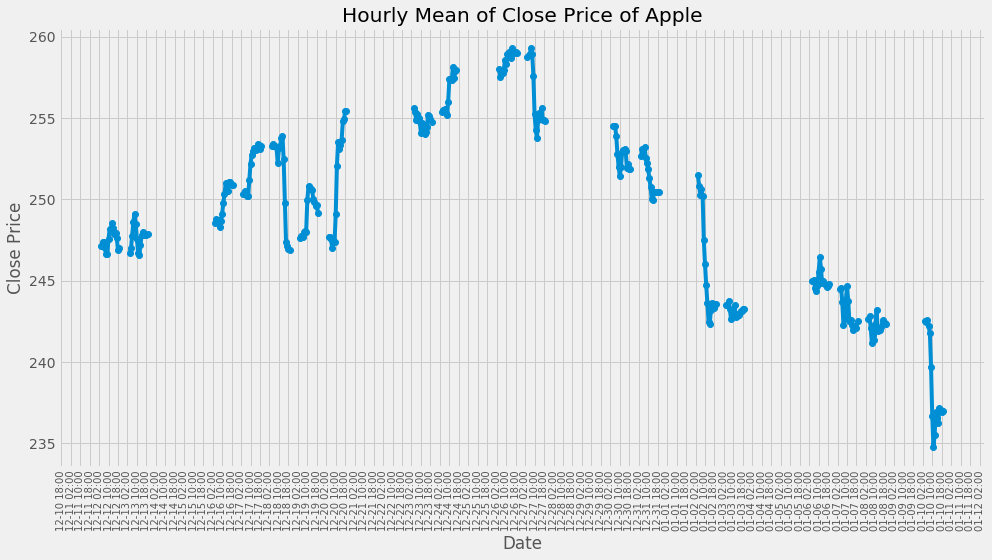

In [142]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator, DateFormatter

fig, ax = plt.subplots(figsize=(14, 8))

# Plot your resampled data
ax.plot(hourly_mean.index, hourly_mean, marker='o')
ax.set_title('Hourly Mean of Close Price of Apple')

# Set ticks every 12 hours
ax.xaxis.set_major_locator(HourLocator(interval=8))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))

# Manually control label rotation and fontsize
ax.tick_params(axis='x', labelrotation=90, labelsize=10)

# NO fig.autofmt_xdate() call here
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')

plt.tight_layout()  # Prevent cutting off the rotated labels
plt.show()


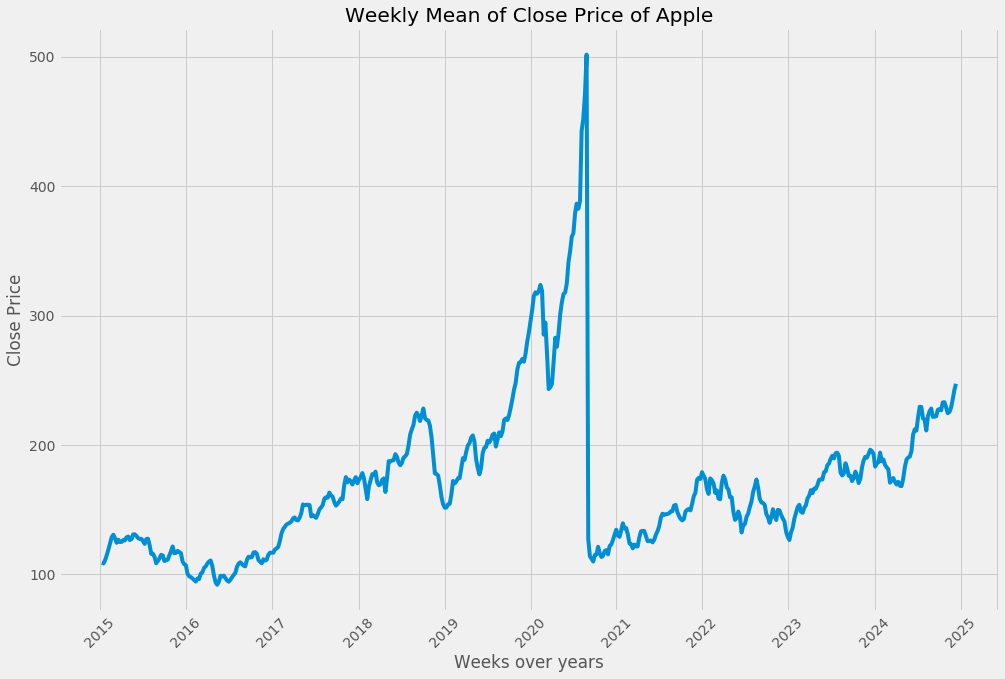

In [132]:
apple_intra_df_copy = apple_intra_df.copy()
plt.figure(figsize = (15,10))
apple_intra_df_copy.set_index('Datetime',inplace = True)
apple_intra_df_copy['Close_daily'].resample('W').mean().plot()
plt.title('Weekly Mean of Close Price of Apple')
plt.xticks(rotation = 45)
plt.xlabel('Weeks over years')
plt.ylabel('Close Price');

In [80]:
## Preprocessing for Prophet

train_subset = train_subset.reset_index().rename(columns={'Datetime':'ds',
                     'Close':'y'})

test_subset = test_subset.reset_index().rename(columns={'Datetime':'ds',
                     'Close':'y'})

train_subset_intra = train_subset_intra.reset_index().rename(columns={'Datetime':'ds',
                     'Return':'y'})

test_subset_intra = test_subset_intra.reset_index().rename(columns={'Datetime':'ds',
                     'Return':'y'})



## Hourly Apple model

In [28]:
%%time
model_apple= Prophet(yearly_seasonality = False)
model_apple.fit(train_subset)

CPU times: user 28 s, sys: 40.4 ms, total: 28 s
Wall time: 27.9 s


In [ ]:
apple_preds = model_apple.predict(test_subset)

## Daily Apple Model

In [34]:
%%time
model_apple_intra = Prophet(daily_seasonality = True)
model_apple_intra.fit(train_subset_intra)

CPU times: user 207 ms, sys: 2.11 ms, total: 209 ms
Wall time: 207 ms


In [49]:
apple_preds_intra = model_apple_intra.predict(test_subset_intra)

In [53]:
apple_test.set_index('Datetime',inplace = True)
apple_test_intra.set_index('Datetime',inplace = True)

# Plotting Apple Hourly stock

## Model Components

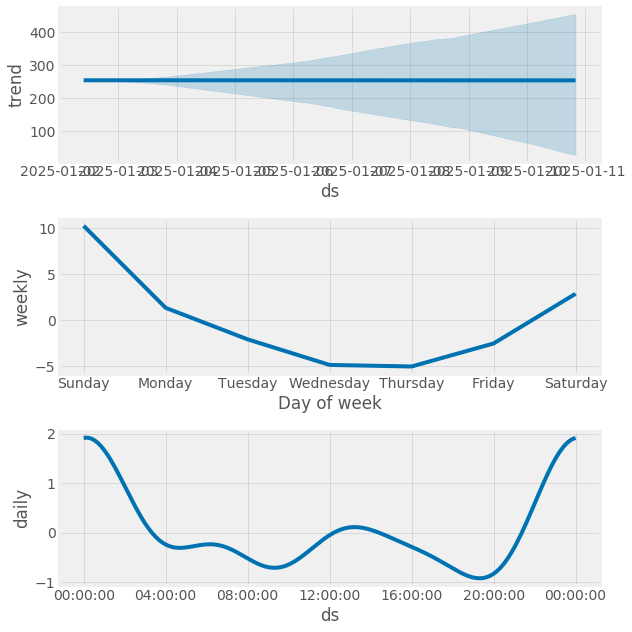

In [84]:
fig = model_apple.plot_components(apple_preds)
plt.show()

## Forecast

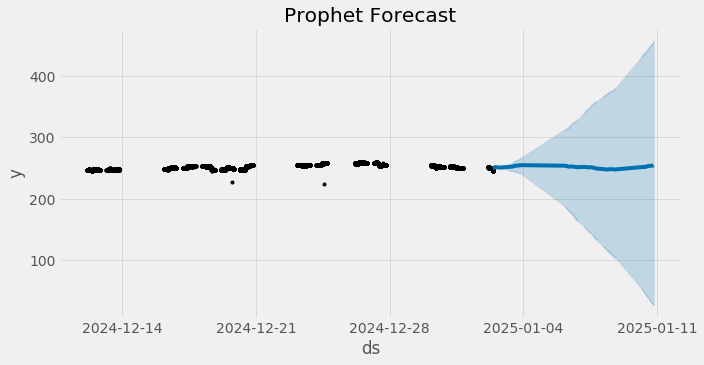

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_apple.plot(apple_preds, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

## Real Close values vs predicted values

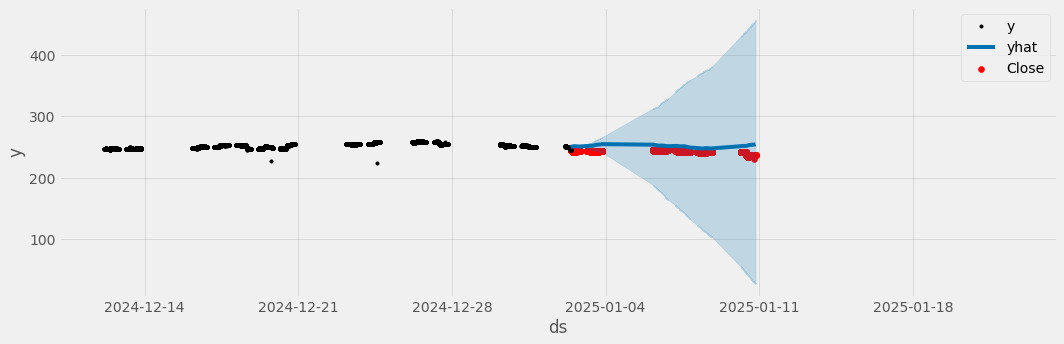

In [42]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test.index, apple_test['Close'], color = 'r')
fig = model_apple.plot(apple_preds, ax=ax)
plt.legend()


In [44]:
train_subset.loc[len(train_subset)-1]['ds']

Timestamp('2025-01-02 09:43:00')

## Focusing on specific interval

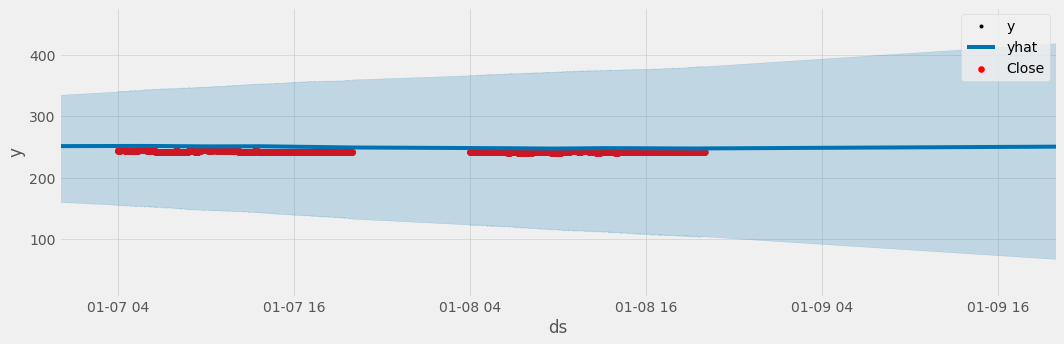

In [102]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test.index, apple_test['Close'], color = 'r')
fig = model_apple.plot(apple_preds, ax=ax)
ax.set_xbound(lower='01-07-2025',
              upper='2025-01-09 20')
plt.legend()


## Future predictions

In [100]:
future = model_apple.make_future_dataframe(periods=1000, freq='min', include_history=False)
forecast = model_apple.predict(future)

In [101]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
995,2025-01-03 02:19:00,254.609486,249.264981,255.780124,251.022267,257.676026,-1.725322,-1.725322,-1.725322,0.685532,0.685532,0.685532,-2.410854,-2.410854,-2.410854,0.0,0.0,0.0,252.884164
996,2025-01-03 02:20:00,254.609463,249.085811,256.104607,251.016621,257.681028,-1.737750,-1.737750,-1.737750,0.672156,0.672156,0.672156,-2.409906,-2.409906,-2.409906,0.0,0.0,0.0,252.871713
997,2025-01-03 02:21:00,254.609440,248.994569,256.075025,251.011136,257.685820,-1.750139,-1.750139,-1.750139,0.658818,0.658818,0.658818,-2.408957,-2.408957,-2.408957,0.0,0.0,0.0,252.859301
998,2025-01-03 02:22:00,254.609417,249.164831,255.902273,251.005651,257.690612,-1.762485,-1.762485,-1.762485,0.645519,0.645519,0.645519,-2.408005,-2.408005,-2.408005,0.0,0.0,0.0,252.846932
999,2025-01-03 02:23:00,254.609394,249.230632,255.861017,251.000166,257.695404,-1.774788,-1.774788,-1.774788,0.632262,0.632262,0.632262,-2.407051,-2.407051,-2.407051,0.0,0.0,0.0,252.834606


## Plotting Apple Daily stock

## Model compomemts

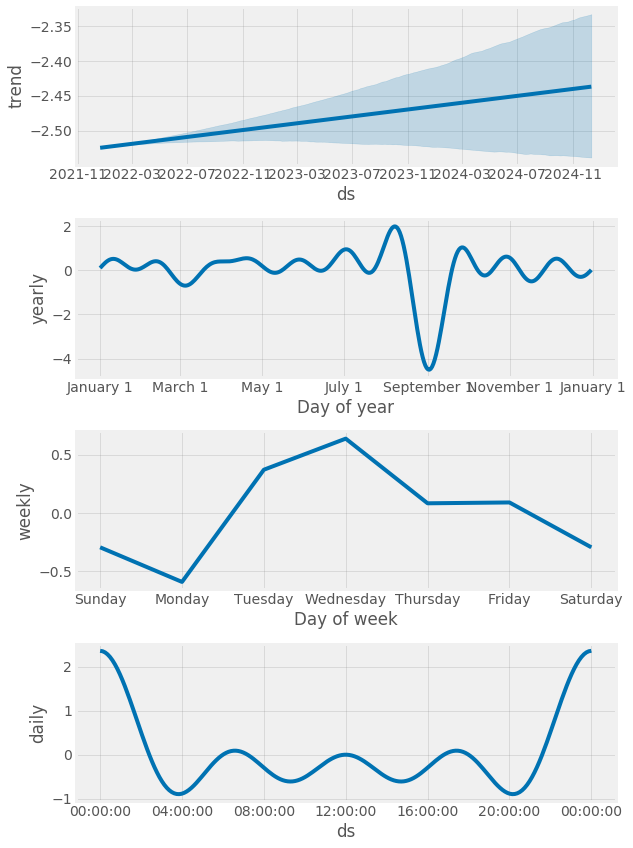

In [83]:
fig = model_apple_intra.plot_components(apple_preds_intra)
plt.show()

## Forecast

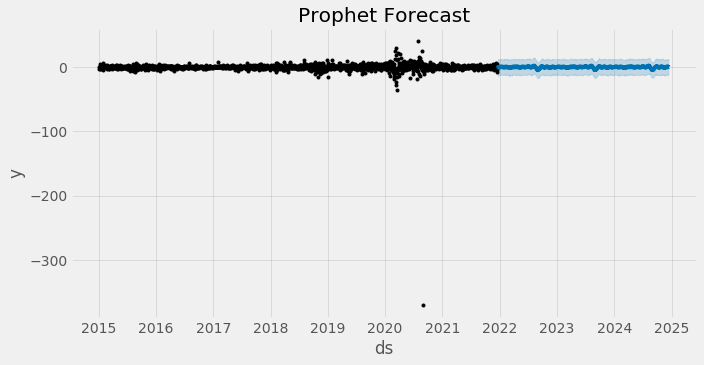

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

## Real Return values vs predicted Returns

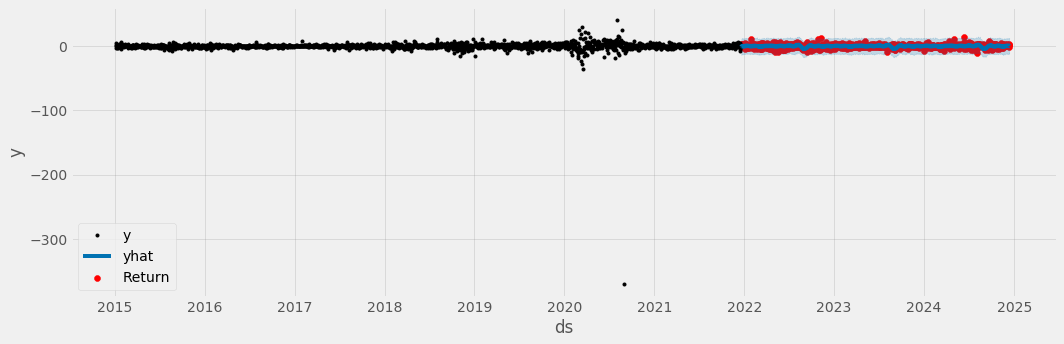

In [55]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Return'], color = 'r')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
plt.legend()

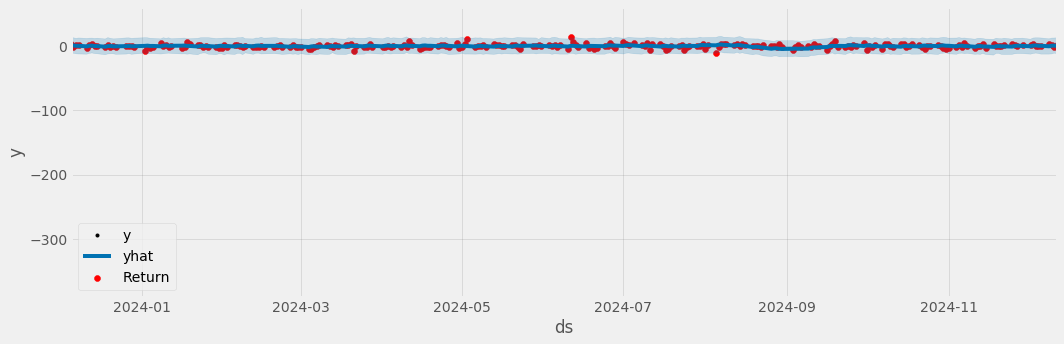

In [64]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(apple_test_intra.index, apple_test_intra['Return'], color = 'r')
fig = model_apple_intra.plot(apple_preds_intra, ax=ax)
ax.set_xbound(lower='12-05-2023',
              upper='2024-12-12')
plt.legend()

## Future Predictions

In [106]:
future_intra = model_apple_intra.make_future_dataframe(periods=365*5, freq='d', include_history=False)
forecast_intra = model_apple_intra.predict(future_intra)

In [107]:
forecast_intra.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1820,2026-12-12,-2.378052,-11.151217,12.928219,-2.611668,-2.127782,2.337993,2.337993,2.337993,2.361024,2.361024,2.361024,-0.295128,-0.295128,-0.295128,0.272097,0.272097,0.272097,0.0,0.0,0.0,-0.040059
1821,2026-12-13,-2.377971,-12.297078,12.444223,-2.611671,-2.127555,2.268950,2.268950,2.268950,2.361024,2.361024,2.361024,-0.295128,-0.295128,-0.295128,0.203054,0.203054,0.203054,0.0,0.0,0.0,-0.109021
1822,2026-12-14,-2.377891,-12.419666,11.770879,-2.611674,-2.127327,1.899986,1.899986,1.899986,2.361024,2.361024,2.361024,-0.592347,-0.592347,-0.592347,0.131309,0.131309,0.131309,0.0,0.0,0.0,-0.477905
1823,2026-12-15,-2.377810,-12.123114,12.200156,-2.611677,-2.127099,2.791400,2.791400,2.791400,2.361024,2.361024,2.361024,0.371292,0.371292,0.371292,0.059085,0.059085,0.059085,0.0,0.0,0.0,0.413590
1824,2026-12-16,-2.377729,-12.365970,13.101798,-2.611680,-2.126871,2.987828,2.987828,2.987828,2.361024,2.361024,2.361024,0.638215,0.638215,0.638215,-0.011411,-0.011411,-0.011411,0.0,0.0,0.0,0.610099
